In [ ]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import cmasher as cmr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params import get_photometry, get_luminosity_function, get_colour_distribution

# base directories
base_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/1P"
input_dir = f"{base_dir}/photometry"

# redshift mappings
redshift_values = {
    '044': {'redshift': 2.00, 'label': 'z2.0'},
    '052': {'redshift': 1.48, 'label': 'z1.5'},
    '060': {'redshift': 1.05, 'label': 'z1.0'},
    '086': {'redshift': 0.10, 'label': 'z0.1'}
}

# LFs
lf_output_dir = {
    "observed": {
        "GALEX": f"{base_dir}/LFs/observed/GALEX"  # contains only attenuated flux from observed GALEX
    },
    "restframe": {
        "UV1500": f"{base_dir}/LFs/restframe/UV1500",
        "GALEX": f"{base_dir}/LFs/restframe/GALEX" # contains only rest frame luminosity and uses GALEX filters
    }
}

# colours
colour_output_dir = {
    "observed": {
        "GALEX": f"{base_dir}/colours/observed/GALEX"
    },
    "restframe": {
        "UV1500": f"{base_dir}/colours/restframe/UV1500",
        "GALEX": f"{base_dir}/colours/restframe/GALEX"
    }
}

# directories including redshift subdirectories
for category in ["observed", "restframe"]:
    for band_tel, path in lf_output_dir[category].items():
        for redshift_info in redshift_values.values():
            redshift_dir = os.path.join(path, redshift_info['label'])
            os.makedirs(redshift_dir, exist_ok=True)
            
    for band_tel, path in colour_output_dir[category].items():
        for redshift_info in redshift_values.values():
            redshift_dir = os.path.join(path, redshift_info['label'])
            os.makedirs(redshift_dir, exist_ok=True)

# parameters
uvlf_limits = (-24, -16)
uvlf_nbins =11
colour_limits = (-0.5, 3.5)
nbins_colour = 20

# magnitude limits (DIS) from https://iopscience.iop.org/article/10.1086/520512/pdf
NUV_mag_lim = 24.4
FUV_mag_lim = 24.8

# band dictionary, either rest frame or from filter/band_tel
band_dict = {
    "GALEX": { # band/telescope
        "category": "observed",
        "types": ["attenuated", "intrinsic"],
        "bands": {
            "FUV": {
                "filter_name": "GALEX FUV",
                "mag_limit": FUV_mag_lim
            },
            "NUV": {
                "filter_name": "GALEX NUV",
                "mag_limit": NUV_mag_lim
            }
        },
        "uvlf_limits": uvlf_limits,
        "uvlf_nbins": uvlf_nbins,
        "colour_pairs": [
            {
                "band1": "FUV",
                "band2": "NUV",
                "limits": colour_limits,
                "nbins": nbins_colour
            }
        ]
    },
    "UV1500": {# band/telescope
        "category": "restframe",
        "type": "restframe",
        "wavelength": "UV1500",
        "bands": {
            "UV1500": {
                "filter_name": "UV1500",
                "mag_limit": None
            }
        },
        "uvlf_limits": uvlf_limits,
        "uvlf_nbins": uvlf_nbins,
        "colour_pairs": []
    }
}

In [2]:
def get_restframe_uvlf(sim_name, snap, wavelength, band_dict):
    """Get UVLF for a restframe wavelength"""
    file_path = os.path.join(input_dir, f"IllustrisTNG_{sim_name}_photometry.hdf5")
    with h5py.File(file_path, 'r') as hdf:
        luminosity = hdf[f'/snap_{snap}/BC03/photometry/luminosity/intrinsic/{wavelength}'][:]
        luminosity_unyt = luminosity * erg / (Hz * s)
        abs_mags = lnu_to_absolute_mag(luminosity_unyt)
        
        phi, phi_sigma, hist, bin_lims = get_luminosity_function(
            {wavelength: abs_mags},
            wavelength,
            *band_dict["uvlf_limits"],
            n_bins=band_dict["uvlf_nbins"]
        )
        
        return phi, phi_sigma, hist, bin_lims

def get_observed_uvlf(sim_name, snap, filter_info, spec_type, band_dict):
    """Get UVLF for an observed filter"""
    photo = get_photometry(
        sim_name=sim_name,
        spec_type=spec_type,
        snap=snap,
        sps="BC03",
        model="IllustrisTNG",
        filters=[filter_info["filter_name"]],
        photo_dir=input_dir
    )
    
    # some magnitude conversion here, need to test.
    # I cant remember what the issue was before but the conversion from flux to ab mags wasn't right...
    phi, phi_sigma, hist, bin_lims = get_luminosity_function(
        photo,
        filter_info["filter_name"],
        *band_dict["uvlf_limits"],
        n_bins=band_dict["uvlf_nbins"]
    )
    
    return phi, phi_sigma, hist, bin_lims

def get_observed_colour(sim_name, snap, colour_pair, band_dict, spec_type):
    """Get colour distribution for a pair of filters"""
    filters = [
        band_dict["bands"][colour_pair["band1"]]["filter_name"],
        band_dict["bands"][colour_pair["band2"]]["filter_name"]
    ]
    
    photo = get_photometry(
        sim_name=sim_name,
        spec_type=spec_type,
        snap=snap,
        sps="BC03",
        model="IllustrisTNG",
        filters=filters,
        photo_dir=input_dir
    )
    
    # make magnitude limit masks
    masks = {
        band: photo[band_dict["bands"][band]["filter_name"]] < band_dict["bands"][band]["mag_limit"]
        for band in [colour_pair["band1"], colour_pair["band2"]]
    }
    combined_mask = masks[colour_pair["band1"]] & masks[colour_pair["band2"]]
    
    # then get mags for each band and then calc colour
    colour_dist, bin_lims = get_colour_distribution(
        photo,
        band_dict["bands"][colour_pair["band1"]]["filter_name"],
        band_dict["bands"][colour_pair["band2"]]["filter_name"],
        *colour_pair["limits"],
        n_bins=colour_pair["nbins"],
        mask=combined_mask
    )
    
    return colour_dist, bin_lims

def process_observed_data(sim_name, snap, band_tel, band_dict):
    """Process all data for a given band_tel"""
    category = band_dict["category"]
    
    if category == "restframe":
        # get restframe wavelength from 'band_tel' parameters
        wavelength = band_dict["wavelength"]
        phi, phi_sigma, hist, bin_lims = get_restframe_uvlf(
            sim_name, snap, wavelength, band_dict
        )
        return {
            'uvlf': {wavelength: (phi, phi_sigma, hist, bin_lims)},
            'colours': {}
        }
    
    else:  # observed
        results = {'uvlf': {}, 'colours': {}}
        spec_types = band_dict.get("types", ["intrinsic"])
        
        for spec_type in spec_types:
            # get UVLFs for each band
            for band, filter_info in band_dict["bands"].items():
                phi, phi_sigma, hist, bin_lims = get_observed_uvlf(
                    sim_name, snap, filter_info, spec_type, band_dict
                )
                results['uvlf'][f"{band}_{spec_type}"] = (phi, phi_sigma, hist, bin_lims)
            
            # get colours if any colour pairs defined
            for colour_pair in band_dict.get("colour_pairs", []):
                colour_name = f"{colour_pair['band1']}-{colour_pair['band2']}"
                colour_dist, bin_lims = get_colour_distribution(
                    sim_name, snap, colour_pair, band_dict, spec_type
                )
                results['colours'][f"{colour_name}_{spec_type}"] = (colour_dist, bin_lims)
        
        return results

Processing observed band example...

Processing 1P_p1_0 for z=0.1

Calculating observed UVLFs for GALEX


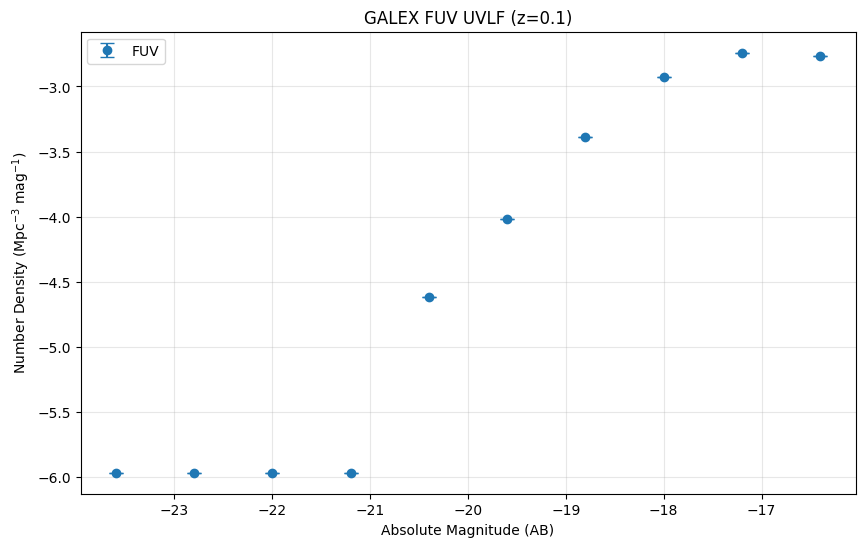

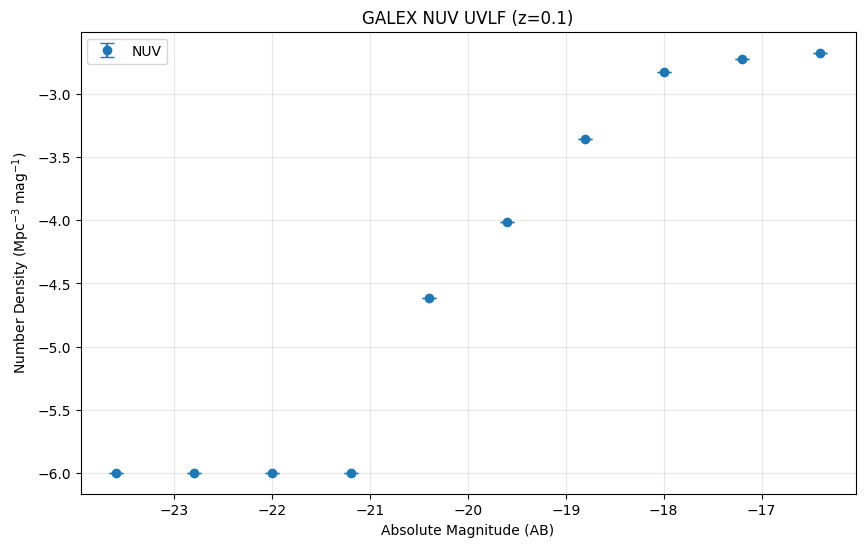


Calculating observed colours for GALEX


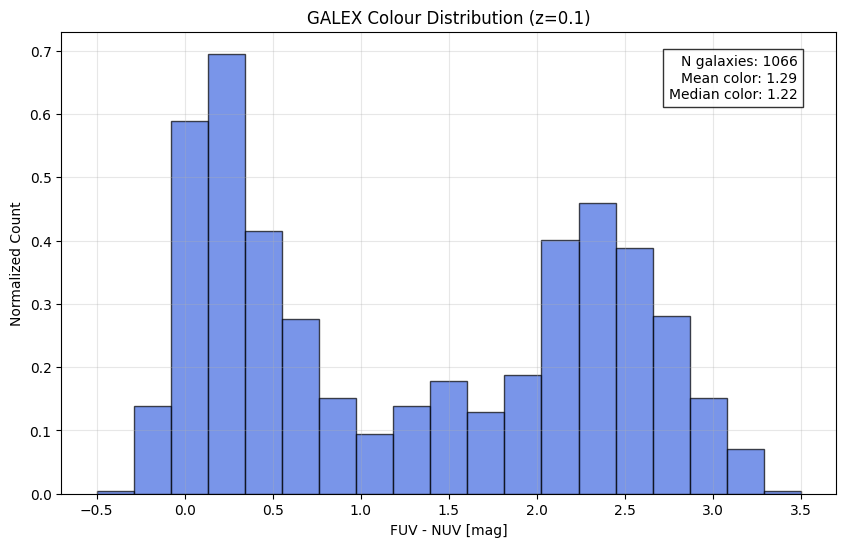


Processing rest frame band example...

Processing 1P_p1_0 for z=0.1

Calculating rest frame UVLF for UV1500


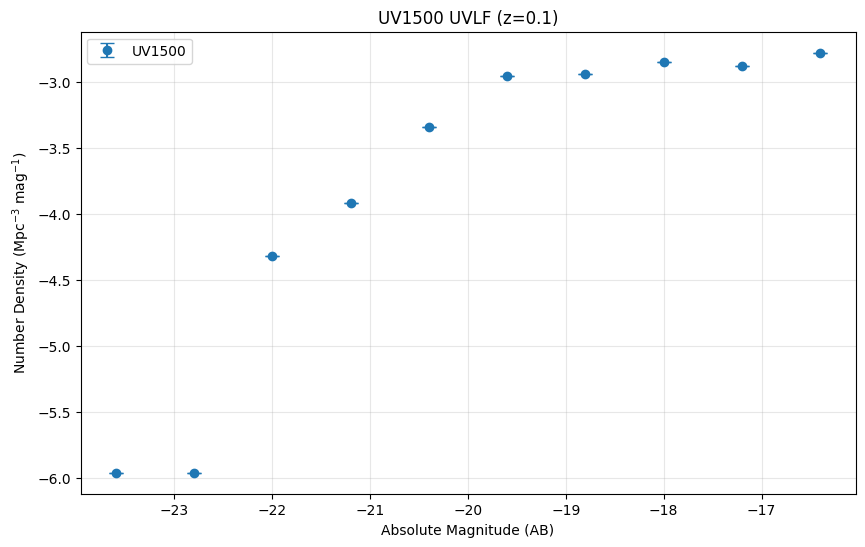

In [ ]:
def process_single_file_example(sim_name, snap, spec_type, band_tel):
   """Process single file example for both UVLF and colours"""
       
   print(f"\nProcessing {sim_name} for z={redshift_values[snap]['redshift']}")
   
   if band_dict[band_tel]["category"] == "observed":
       # get observed UVLF
       print(f"\nCalculating observed UVLFs for {band_tel}")
       for band in band_dict[band_tel]["bands"]:
           phi, phi_sigma, hist, bin_lims = get_observed_uvlf(
               sim_name, 
               snap,
               band_dict[band_tel]["bands"][band],
               spec_type,
               band_dict[band_tel]
           )
           
           # save UVLF
           bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
           uvlf_df = pd.DataFrame({
               'magnitude': bin_centers,
               'phi': phi,
               'phi_sigma': phi_sigma,
               'hist': hist
           })
           
           uvlf_filename = f"UVLF_{sim_name}_{band}_{redshift_values[snap]['label']}_{spec_type}.txt"
           redshift_dir = os.path.join(lf_output_dir["observed"][band_tel], 
                                     redshift_values[snap]['label'])
           uvlf_df.to_csv(
               os.path.join(redshift_dir, uvlf_filename), 
               index=False, sep='\t'
           )
           
           # plt uvlf
           plt.figure(figsize=(10, 6))
           plt.errorbar(bin_centers, phi, yerr=phi_sigma, fmt='o', 
                       label=band, capsize=5)
           plt.xlabel('Absolute Magnitude (AB)')
           plt.ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
           plt.title(f'{band_tel} {band} UVLF (z={redshift_values[snap]["redshift"]})')
           plt.grid(True, alpha=0.3)
           plt.legend()
           plt.show()
       
       # get observed colours
       print(f"\nCalculating observed colours for {band_tel}")
       if band_dict[band_tel]["colour_pairs"]:
           colour_pair = band_dict[band_tel]["colour_pairs"][0]
           colour_dist, bin_lims = get_observed_colour(
               sim_name,
               snap,
               colour_pair,
               band_dict[band_tel],
               spec_type
           )
           
           # save colours
           bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
           colour_df = pd.DataFrame({
               'colour': bin_centers,
               'distribution': colour_dist
           })
           
           colour_name = f"{colour_pair['band1']}-{colour_pair['band2']}"
           colour_filename = f"Colour_{sim_name}_{colour_name}_{redshift_values[snap]['label']}_{spec_type}.txt"
           redshift_dir = os.path.join(colour_output_dir["observed"][band_tel], 
                                     redshift_values[snap]['label'])
           colour_df.to_csv(
               os.path.join(redshift_dir, colour_filename), 
               index=False, sep='\t'
           )
           
           # get photometry for plotting actual color distribution
           photo = get_photometry(
               sim_name=sim_name,
               spec_type=spec_type,
               snap=snap,
               sps="BC03",
               model="IllustrisTNG",
               filters=[band_dict[band_tel]["bands"][b]["filter_name"] for b in ["FUV", "NUV"]],
               photo_dir=input_dir
           )
           
           # make masks
           masks = {
               band: photo[band_dict[band_tel]["bands"][band]["filter_name"]] < band_dict[band_tel]["bands"][band]["mag_limit"]
               for band in ["FUV", "NUV"]
           }
           combined_mask = masks["FUV"] & masks["NUV"]
           
           # plt colour
           plt.figure(figsize=(10, 6))
           colours = photo["GALEX FUV"][combined_mask] - photo["GALEX NUV"][combined_mask]
           plt.hist(colours, bins=bin_lims, density=True, alpha=0.7,
                   color='royalblue', edgecolor='black', linewidth=1)
           plt.xlabel('FUV - NUV [mag]')
           plt.ylabel('Normalized Count')
           plt.title(f'{band_tel} Colour Distribution (z={redshift_values[snap]["redshift"]})')
           plt.grid(True, alpha=0.3)
           
           # Add statistics
           stats_text = f'N galaxies: {len(colours)}\n'
           stats_text += f'Mean color: {np.mean(colours):.2f}\n'
           stats_text += f'Median color: {np.median(colours):.2f}'
           plt.text(0.95, 0.95, stats_text,
                   transform=plt.gca().transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(facecolor='white', alpha=0.8))
           plt.show()
   
   else:  # restframe processing
       print(f"\nCalculating rest frame UVLF for {band_tel}")
       wavelength = band_dict[band_tel]["wavelength"]
       phi, phi_sigma, hist, bin_lims = get_restframe_uvlf(
           sim_name, 
           snap,
           wavelength,
           band_dict[band_tel]
       )
       
       # save UVLF
       bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
       uvlf_df = pd.DataFrame({
           'magnitude': bin_centers,
           'phi': phi,
           'phi_sigma': phi_sigma,
           'hist': hist
       })
       
       uvlf_filename = f"UVLF_{sim_name}_{wavelength}_{redshift_values[snap]['label']}.txt"
       redshift_dir = os.path.join(lf_output_dir["restframe"][band_tel], 
                                 redshift_values[snap]['label'])
       uvlf_df.to_csv(
           os.path.join(redshift_dir, uvlf_filename), 
           index=False, sep='\t'
       )
       
       # plt uvlf
       plt.figure(figsize=(10, 6))
       plt.errorbar(bin_centers, phi, yerr=phi_sigma, fmt='o', 
                   label=wavelength, capsize=5)
       plt.xlabel('Absolute Magnitude (AB)')
       plt.ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
       plt.title(f'{band_tel} UVLF (z={redshift_values[snap]["redshift"]})')
       plt.grid(True, alpha=0.3)
       plt.legend()
       plt.show()

if __name__ == "__main__":
   # GALEX (observed example)
   print("Processing observed band example...")
   process_single_file_example(
       sim_name="1P_p1_0",
       snap="086",  # z=0.1
       spec_type="attenuated",
       band_tel="GALEX"
   )
   
   # UV1500 (restframe example)
   print("\nProcessing rest frame band example...")
   process_single_file_example(
       sim_name="1P_p1_0",
       snap="086",  # z=0.1
       spec_type="restframe",
       band_tel="UV1500"
   )

In [4]:
phi, phi_sigma, hist, bin_lims = get_observed_uvlf(
    sim_name="1P_p1_0",
    snap="086",  # z=0.1
    filter_info=band_dict["GALEX"]["bands"]["FUV"],  # Fetch FUV's filter info
    spec_type="attenuated",
    band_dict=band_dict["GALEX"]  # Ensures full GALEX data is still used
)


In [5]:
print('phi:',phi)
print('bin_lims:',bin_lims)
print('phi_sigma:',phi_sigma)


phi: [-5.97985479 -5.97985479 -5.97985479 -5.97985479 -4.6165483  -4.01448831
 -3.38609938 -2.92635222 -2.74148703 -2.76528995]
bin_lims: [-24.  -23.2 -22.4 -21.6 -20.8 -20.  -19.2 -18.4 -17.6 -16.8 -16. ]
phi_sigma: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.41797443e-05 4.83594885e-05 9.96956396e-05 1.69258210e-04
 2.09402728e-04 2.03742147e-04]


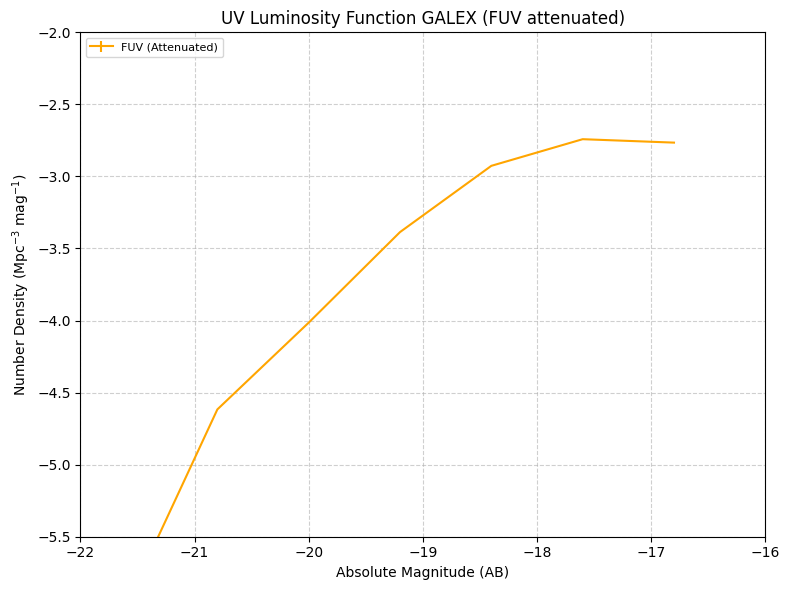

In [6]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', alpha=0.6)

ax.errorbar(bin_lims[:-1], phi, phi_sigma, label="FUV (Attenuated)", color="orange", ls='-', zorder=2)
'''

ax.fill_between(bin_lims[:-1], 
                phi - phi_sigma, 
                phi + phi_sigma, 
                color="orange", alpha=0.3, zorder=1)
'''
# set x and y lims
ax.set_xlim(-22,-16)
ax.set_ylim(-5.5,-2)

# add labels and title
ax.set_xlabel('Absolute Magnitude (AB)')
ax.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
ax.legend(loc='upper left', fontsize=8)
ax.set_title("UV Luminosity Function GALEX (FUV attenuated)")

plt.tight_layout()
plt.show()